
# 0) Evaluating RAG Retrievers (Hugging Face) — Extended
**Audience:** 4th‑year CS students  
**Goal:** Quantify retrieval performance for a RAG pipeline using IR metrics, and compare **dense**, **BM25**, **hybrid**, and **reranked** approaches. Optionally, run an **end‑to‑end** generation step with a small model.

**What you'll build and measure:**
- Core IR metrics: **Precision@5/@10**, **Recall@5/@10**, **MAP**, **MRR**
- Dense retriever baseline with `sentence-transformers/all-MiniLM-L6-v2`
- **(6)** BM25 sparse baseline (`rank_bm25`)
- **(7)** Hybrid dense + sparse (score fusion)
- **(9)** Cross‑encoder reranker (`cross-encoder/ms-marco-MiniLM-L-6-v2`)
- **(11)** Optional end‑to‑end generation using `google/flan-t5-base` (Apache‑2.0)

### Dataset (Legal)
We use **SQuAD v1.1** (via 🤗 `datasets`) — **CC BY‑SA 4.0** — a widely used QA dataset.  
- **Document** = unique `context` paragraph  
- **Query** = the corresponding `question`  
- **Ground truth** = the `doc_id` of the paragraph that generated the question

> For clarity and speed, we assume **one relevant document per query**.


In [ ]:

# ======= 0.1) Install dependencies (uncomment if needed) =======
# !pip install -U datasets transformers sentence-transformers rank_bm25 numpy pandas tqdm matplotlib
# Optional for scale:
# !pip install faiss-cpu
# !pip install rank_bm25


In [2]:

# ======= 0.2) Imports and configuration =======
from datasets import load_dataset
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer, CrossEncoder
from rank_bm25 import BM25Okapi
from transformers import pipeline

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

N_EXAMPLES = 400
MAX_DOCS = 350
TOP_KS = [5, 10]

DENSE_MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
RERANKER_MODEL_NAME = "cross-encoder/ms-marco-MiniLM-L-6-v2"
GEN_MODEL_NAME = "google/flan-t5-base"

import rag_pipeline_api as rpa


## 1) Load dataset and construct corpus + queries

In [3]:

# ======= 1.1) Load SQuAD v1.1 =======
squad = load_dataset("squad", split="validation")
df = squad.to_pandas()[["id", "title", "context", "question", "answers"]]
df = df.sample(frac=1.0, random_state=RANDOM_SEED).head(N_EXAMPLES).reset_index(drop=True)
print(f"Loaded {len(df)} SQuAD examples.")
df.head(3)


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

plain_text/validation-00000-of-00001.par(…):   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

Loaded 400 SQuAD examples.


,id,title,context,question,answers
0,571cd3b55efbb31900334e04,Oxygen,Hyperbaric (high-pressure) medicine uses speci...,What does increased oxygen concentrations in t...,"{'text': ['carbon monoxide', 'carbon monoxide'..."
1,57097d63ed30961900e841fd,Sky_(United_Kingdom),The agreements include fixed annual carriage f...,Does the new deal include Video on demand and ...,"{'text': ['no', 'no indication', 'no indicatio..."
2,572754cd5951b619008f8866,Genghis_Khan,"The invasions of Baghdad, Samarkand, Urgench, ...",In which year did Genghis Khan's grandson inva...,"{'text': ['1237', '1237', '1237'], 'answer_sta..."


In [4]:

# ======= 1.2) Build corpus of unique documents (contexts) =======
unique_contexts = pd.Series(df["context"].unique())
if len(unique_contexts) > MAX_DOCS:
    unique_contexts = unique_contexts.sample(n=MAX_DOCS, random_state=RANDOM_SEED).reset_index(drop=True)

doc_df = pd.DataFrame({
    "doc_id": np.arange(len(unique_contexts), dtype=int),
    "text": unique_contexts
})
context_to_docid = {ctx: i for i, ctx in enumerate(unique_contexts)}

print(f"Corpus size (unique documents): {len(doc_df)}")
doc_df.head(2)


Corpus size (unique documents): 350


,doc_id,text
0,0,The 2005 version of Doctor Who is a direct plo...
1,1,Courts have distinguished between two types of...


In [6]:

# ======= 1.3) Build query set with ground-truth doc IDs =======
def map_context_to_docid(ctx):
    return context_to_docid.get(ctx, None)

query_rows = []
for _, row in df.iterrows():
    did = map_context_to_docid(row["context"])
    if did is None:
        continue
    query_rows.append({
        "question_id": row["id"],
        "question": row["question"],
        "relevant_doc_id": int(did),
        "title": row["title"]
    })
query_df = pd.DataFrame(query_rows).reset_index(drop=True)
print(f"Queries retained after trimming: {len(query_df)}")
query_df.head(3)


Queries retained after trimming: 383


,question_id,question,relevant_doc_id,title
0,571cd3b55efbb31900334e04,What does increased oxygen concentrations in t...,16,Oxygen
1,57097d63ed30961900e841fd,Does the new deal include Video on demand and ...,310,Sky_(United_Kingdom)
2,572754cd5951b619008f8866,In which year did Genghis Khan's grandson inva...,199,Genghis_Khan


## 2) Dense embeddings (bi‑encoder)

In [7]:

# ======= 2.1) Encode documents and queries =======
dense_model = SentenceTransformer(DENSE_MODEL_NAME)
doc_embeddings = dense_model.encode(doc_df["text"].tolist(), convert_to_numpy=True, show_progress_bar=True)
query_embeddings = dense_model.encode(query_df["question"].tolist(), convert_to_numpy=True, show_progress_bar=True)
doc_embeddings.shape, query_embeddings.shape


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Batches:   0%|          | 0/12 [00:00<?, ?it/s]

((350, 384), (383, 384))

In [8]:

# ======= 2.2) Dense retrieval helper (cosine similarity) =======
def dense_ranked_docs_for_query(q_vec, doc_vecs):
    q = q_vec / (np.linalg.norm(q_vec) + 1e-12)
    D = doc_vecs / (np.linalg.norm(doc_vecs, axis=1, keepdims=True) + 1e-12)
    sims = D @ q
    ranked_doc_ids = np.argsort(-sims)
    return ranked_doc_ids, sims[ranked_doc_ids]


## 3) Metrics

In [9]:

# ======= 3.1) Metric implementations =======
def precision_at_k(ranked_doc_ids, relevant_doc_ids, k):
    ranked_k = ranked_doc_ids[:k]
    hits = sum(1 for d in ranked_k if d in relevant_doc_ids)
    return hits / float(k)

def recall_at_k(ranked_doc_ids, relevant_doc_ids, k):
    ranked_k = ranked_doc_ids[:k]
    hits = sum(1 for d in ranked_k if d in relevant_doc_ids)
    return hits / float(len(relevant_doc_ids)) if len(relevant_doc_ids) > 0 else 0.0

def average_precision(ranked_doc_ids, relevant_doc_ids):
    if len(relevant_doc_ids) == 0:
        return 0.0
    hits = 0
    precisions = []
    for i, d in enumerate(ranked_doc_ids, start=1):
        if d in relevant_doc_ids:
            hits += 1
            precisions.append(hits / i)
    return float(np.mean(precisions)) if precisions else 0.0

def reciprocal_rank(ranked_doc_ids, relevant_doc_ids):
    for i, d in enumerate(ranked_doc_ids, start=1):
        if d in relevant_doc_ids:
            return 1.0 / i
    return 0.0

def evaluate_ranked_list(ranked_doc_ids, relevant_doc_id):
    relevant = {int(relevant_doc_id)}
    metrics = {
        "P@5": precision_at_k(ranked_doc_ids, relevant, 5),
        "P@10": precision_at_k(ranked_doc_ids, relevant, 10),
        "R@5": recall_at_k(ranked_doc_ids, relevant, 5),
        "R@10": recall_at_k(ranked_doc_ids, relevant, 10),
        "AP": average_precision(ranked_doc_ids, relevant),
        "RR": reciprocal_rank(ranked_doc_ids, relevant),
    }
    pos = np.where(ranked_doc_ids == list(relevant)[0])[0]
    metrics["rank_of_relevant"] = int(pos[0]) + 1 if len(pos) else np.inf
    return metrics


## 4) Dense baseline — evaluation

In [10]:

dense_records = []
for i in tqdm(range(len(query_df)), desc="Dense baseline: evaluating queries"):
    ranked_docs, _ = dense_ranked_docs_for_query(query_embeddings[i], doc_embeddings)
    m = evaluate_ranked_list(ranked_docs, query_df.iloc[i]["relevant_doc_id"])
    dense_records.append(m)

dense_df = pd.DataFrame(dense_records)
dense_summary = pd.DataFrame({
    "Metric": ["MAP", "MRR", "Precision@5", "Precision@10", "Recall@5", "Recall@10"],
    "Score":  [dense_df["AP"].mean(), dense_df["RR"].mean(),
               dense_df["P@5"].mean(), dense_df["P@10"].mean(),
               dense_df["R@5"].mean(), dense_df["R@10"].mean()]
})
dense_summary


Dense baseline: evaluating queries: 100%|██████████| 383/383 [00:00<00:00, 3869.13it/s]


,Metric,Score
0,MAP,0.890827
1,MRR,0.890827
2,Precision@5,0.193211
3,Precision@10,0.097650
4,Recall@5,0.966057
5,Recall@10,0.976501


## 5) Dense baseline — rank histogram

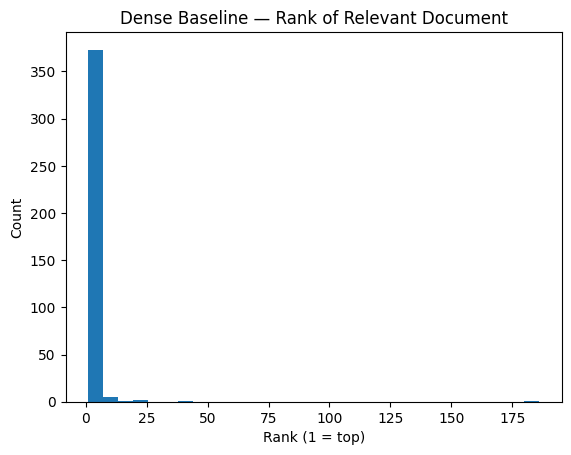

In [11]:

plt.figure()
plt.hist(dense_df["rank_of_relevant"].replace(np.inf, np.nan).dropna(), bins=30)
plt.title("Dense Baseline — Rank of Relevant Document")
plt.xlabel("Rank (1 = top)")
plt.ylabel("Count")
plt.show()


## 6) BM25 sparse baseline

In [12]:

# ======= 6.1) BM25 index =======
def simple_tokenize(text): 
    return text.lower().split()

bm25_corpus_tokens = [simple_tokenize(t) for t in doc_df["text"].tolist()]
bm25 = BM25Okapi(bm25_corpus_tokens)

def bm25_ranked_docs_for_query(query_text):
    q_tokens = simple_tokenize(query_text)
    scores = bm25.get_scores(q_tokens)
    ranked = np.argsort(-scores)
    return ranked, scores[ranked]


In [13]:

bm25_records = []
for i in tqdm(range(len(query_df)), desc="BM25 baseline: evaluating queries"):
    ranked_docs, _ = bm25_ranked_docs_for_query(query_df.iloc[i]["question"])
    m = evaluate_ranked_list(ranked_docs, query_df.iloc[i]["relevant_doc_id"])
    bm25_records.append(m)

bm25_df = pd.DataFrame(bm25_records)
bm25_summary = pd.DataFrame({
    "Metric": ["MAP", "MRR", "Precision@5", "Precision@10", "Recall@5", "Recall@10"],
    "Score":  [bm25_df["AP"].mean(), bm25_df["RR"].mean(),
               bm25_df["P@5"].mean(), bm25_df["P@10"].mean(),
               bm25_df["R@5"].mean(), bm25_df["R@10"].mean()]
})
bm25_summary


BM25 baseline: evaluating queries: 100%|██████████| 383/383 [00:00<00:00, 1323.81it/s]


,Metric,Score
0,MAP,0.793895
1,MRR,0.793895
2,Precision@5,0.178068
3,Precision@10,0.092428
4,Recall@5,0.890339
5,Recall@10,0.924282


## 7) Hybrid dense + BM25 (score fusion)

In [14]:

def minmax_norm(x):
    x = np.asarray(x, dtype=float)
    mn, mx = np.min(x), np.max(x)
    if mx - mn < 1e-12:
        return np.zeros_like(x)
    return (x - mn) / (mx - mn)

def hybrid_ranked_docs_for_query(q_text, q_vec, doc_vecs, alpha=0.5):
    # Dense scores
    q = q_vec / (np.linalg.norm(q_vec) + 1e-12)
    D = doc_vecs / (np.linalg.norm(doc_vecs, axis=1, keepdims=True) + 1e-12)
    dense_scores = D @ q

    # BM25 scores
    q_tokens = q_text.lower().split()
    bm25_scores = bm25.get_scores(q_tokens)

    # Normalize and fuse
    dense_n = minmax_norm(dense_scores)
    bm25_n = minmax_norm(bm25_scores)
    fused = alpha * dense_n + (1 - alpha) * bm25_n

    ranked = np.argsort(-fused)
    return ranked, fused[ranked]


In [15]:

alpha = 0.5
hybrid_records = []
for i in tqdm(range(len(query_df)), desc="Hybrid (dense+BM25): evaluating queries"):
    ranked_docs, _ = hybrid_ranked_docs_for_query(query_df.iloc[i]["question"], query_embeddings[i], doc_embeddings, alpha=alpha)
    m = evaluate_ranked_list(ranked_docs, query_df.iloc[i]["relevant_doc_id"])
    hybrid_records.append(m)

hybrid_df = pd.DataFrame(hybrid_records)
hybrid_summary = pd.DataFrame({
    "Metric": ["MAP", "MRR", "Precision@5", "Precision@10", "Recall@5", "Recall@10"],
    "Score":  [hybrid_df["AP"].mean(), hybrid_df["RR"].mean(),
               hybrid_df["P@5"].mean(), hybrid_df["P@10"].mean(),
               hybrid_df["R@5"].mean(), hybrid_df["R@10"].mean()]
})
hybrid_summary


Hybrid (dense+BM25): evaluating queries: 100%|██████████| 383/383 [00:00<00:00, 1083.74it/s]


,Metric,Score
0,MAP,0.895160
1,MRR,0.895160
2,Precision@5,0.192167
3,Precision@10,0.097389
4,Recall@5,0.960836
5,Recall@10,0.973890


## 8) Compare Dense vs BM25 vs Hybrid

In [16]:

comparison = pd.DataFrame({
    "Metric": ["MAP", "MRR", "Precision@5", "Precision@10", "Recall@5", "Recall@10"],
    "Dense":  [dense_df["AP"].mean(), dense_df["RR"].mean(),
               dense_df["P@5"].mean(), dense_df["P@10"].mean(),
               dense_df["R@5"].mean(), dense_df["R@10"].mean()],
    "BM25":   [bm25_df["AP"].mean(), bm25_df["RR"].mean(),
               bm25_df["P@5"].mean(), bm25_df["P@10"].mean(),
               bm25_df["R@5"].mean(), bm25_df["R@10"].mean()],
    "Hybrid": [hybrid_df["AP"].mean(), hybrid_df["RR"].mean(),
               hybrid_df["P@5"].mean(), hybrid_df["P@10"].mean(),
               hybrid_df["R@5"].mean(), hybrid_df["R@10"].mean()],
})
comparison


,Metric,Dense,BM25,Hybrid
0,MAP,0.890827,0.793895,0.895160
1,MRR,0.890827,0.793895,0.895160
2,Precision@5,0.193211,0.178068,0.192167
3,Precision@10,0.097650,0.092428,0.097389
4,Recall@5,0.966057,0.890339,0.960836
5,Recall@10,0.976501,0.924282,0.973890


## 9) Cross‑encoder reranker (re‑score top‑N)

In [17]:

reranker = CrossEncoder(RERANKER_MODEL_NAME)  # downloads the model first time
TOP_N = 50
BASE_FOR_RERANK = "dense"  # choose "dense" or "hybrid"


In [18]:

def build_full_reranked_list(q_text, base_ranked_ids, top_n=50):
    candidates = base_ranked_ids[:top_n].tolist()
    pairs = [(q_text, doc_df.loc[d, "text"]) for d in candidates]
    scores = reranker.predict(pairs)
    order = np.argsort(-np.array(scores))
    topN_reranked = [candidates[i] for i in order]
    remainder = [d for d in base_ranked_ids.tolist() if d not in set(candidates)]
    return np.array(topN_reranked + remainder, dtype=int)


In [19]:

rerank_records = []
for i in tqdm(range(len(query_df)), desc="Reranker: evaluating queries"):
    q_text = query_df.iloc[i]["question"]
    if BASE_FOR_RERANK == "hybrid":
        base_ranked, _ = hybrid_ranked_docs_for_query(q_text, query_embeddings[i], doc_embeddings, alpha=0.5)
    else:
        base_ranked, _ = dense_ranked_docs_for_query(query_embeddings[i], doc_embeddings)

    full_reranked = build_full_reranked_list(q_text, base_ranked, top_n=TOP_N)
    m = evaluate_ranked_list(full_reranked, query_df.iloc[i]["relevant_doc_id"])
    rerank_records.append(m)

rerank_df = pd.DataFrame(rerank_records)
rerank_summary = pd.DataFrame({
    "Metric": ["MAP", "MRR", "Precision@5", "Precision@10", "Recall@5", "Recall@10"],
    "Score":  [rerank_df["AP"].mean(), rerank_df["RR"].mean(),
               rerank_df["P@5"].mean(), rerank_df["P@10"].mean(),
               rerank_df["R@5"].mean(), rerank_df["R@10"].mean()]
})
rerank_summary


Reranker: evaluating queries: 100%|██████████| 383/383 [00:19<00:00, 19.36it/s]


,Metric,Score
0,MAP,0.976022
1,MRR,0.976022
2,Precision@5,0.198433
3,Precision@10,0.099739
4,Recall@5,0.992167
5,Recall@10,0.997389


## 10) Final comparison (Dense vs BM25 vs Hybrid vs Reranked)

In [20]:

final_comparison = pd.DataFrame({
    "Metric": ["MAP", "MRR", "Precision@5", "Precision@10", "Recall@5", "Recall@10"],
    "Dense":  [dense_df["AP"].mean(), dense_df["RR"].mean(),
               dense_df["P@5"].mean(), dense_df["P@10"].mean(),
               dense_df["R@5"].mean(), dense_df["R@10"].mean()],
    "BM25":   [bm25_df["AP"].mean(), bm25_df["RR"].mean(),
               bm25_df["P@5"].mean(), bm25_df["P@10"].mean(),
               bm25_df["R@5"].mean(), bm25_df["R@10"].mean()],
    "Hybrid": [hybrid_df["AP"].mean(), hybrid_df["RR"].mean(),
               hybrid_df["P@5"].mean(), hybrid_df["P@10"].mean(),
               hybrid_df["R@5"].mean(), hybrid_df["R@10"].mean()],
    "Reranked": [rerank_df["AP"].mean(), rerank_df["RR"].mean(),
                 rerank_df["P@5"].mean(), rerank_df["P@10"].mean(),
                 rerank_df["R@5"].mean(), rerank_df["R@10"].mean()],
})
final_comparison


,Metric,Dense,BM25,Hybrid,Reranked
0,MAP,0.890827,0.793895,0.895160,0.976022
1,MRR,0.890827,0.793895,0.895160,0.976022
2,Precision@5,0.193211,0.178068,0.192167,0.198433
3,Precision@10,0.097650,0.092428,0.097389,0.099739
4,Recall@5,0.966057,0.890339,0.960836,0.992167
5,Recall@10,0.976501,0.924282,0.973890,0.997389


## 11) (Optional) End‑to‑end generation using a small model

In [21]:

STRATEGY = "hybrid"  # "dense"|"bm25"|"hybrid"|"reranked"
K_CONTEXT = 5
MAX_CHARS = 1800

gen = pipeline("text2text-generation", model=GEN_MODEL_NAME)

def retrieve_ids_for_strategy(i):
    q_text = query_df.iloc[i]["question"]
    if STRATEGY == "bm25":
        ranked, _ = bm25_ranked_docs_for_query(q_text)
    elif STRATEGY == "hybrid":
        ranked, _ = hybrid_ranked_docs_for_query(q_text, query_embeddings[i], doc_embeddings, alpha=0.5)
    elif STRATEGY == "reranked":
        base_ranked, _ = hybrid_ranked_docs_for_query(q_text, query_embeddings[i], doc_embeddings, alpha=0.5)
        ranked = build_full_reranked_list(q_text, base_ranked, top_n=50)
    else:
        ranked, _ = dense_ranked_docs_for_query(query_embeddings[i], doc_embeddings)
    return ranked

def build_context_text(doc_ids, k=5, max_chars=1800):
    texts = []
    for d in doc_ids[:k]:
        texts.append(doc_df.loc[d, "text"][: max_chars // k])
    return ("\n\n".join(texts))[:max_chars]

i = 0  # try different queries
q_text = query_df.iloc[i]["question"]
ranked_ids = retrieve_ids_for_strategy(i)
context_block = build_context_text(ranked_ids, k=K_CONTEXT, max_chars=MAX_CHARS)

prompt = f'''Answer the question using ONLY the context. If the answer is not in the context, say so.

Question: {q_text}

Context:
{context_block}

Answer:'''

out = gen(prompt, max_new_tokens=128, do_sample=False)
print("Q:", q_text)
print("A:", out[0]["generated_text"].strip())


Device set to use cuda:0


Q: What does increased oxygen concentrations in the patient's lungs displace?
A: carbon monoxide



## 12) Notes & next steps
- Tune **alpha** in hybrid fusion and observe metric shifts.
- Increase **TOP_N** for reranking; watch when gains saturate.
- Add **faithfulness** checks (string overlap, NLI, or LLM-as-judge).
- Replace brute-force with **FAISS** for scale.
- Try other datasets (mind licensing): **MS MARCO**, **Natural Questions**.
- Chunk contexts to create **multi-relevant** scenarios and compare MAP vs MRR behaviors.
